## 1. Import Standard Libraries

In [1]:
from IPython import display

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional  as F

## 2. Create the Data

In [4]:
nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# Generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()

# note: "long" format for CCE (Multi-class)
labels = torch.tensor(labels_np).long()  

## 3. Data Visualization

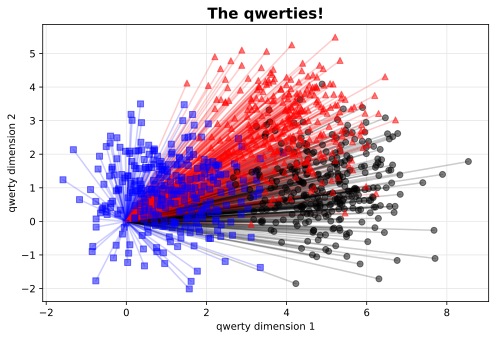

In [5]:
fig = plt.figure(figsize=(8,5),dpi = 140)

# color string : blue,black,red
color = 'bkr'

# draw distance to origin
for i in range(len(data)):
    plt.plot([0,data[i,0]],[0,data[i,1]],color=color[labels[i]],alpha=.2)

plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)

plt.grid(color=[.9,.9,.9])
plt.title('The qwerties!',fontsize=15,fontweight="bold")
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')

plt.show()

## 4. Compute Euclidean distance

In [6]:
# Adding a 3rd dimension as a Euclidean distance of a point from origin.

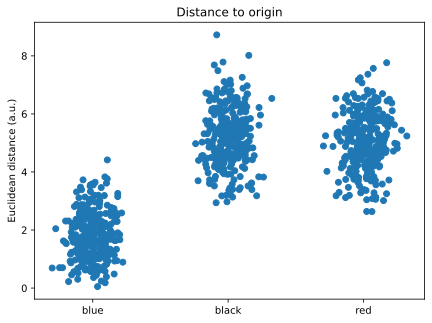

In [7]:
# Compute Euclidean distance to the origin
distfrom_orig = torch.sqrt( data[:,0]**2 + data[:,1]**2 )

# Returns a tensor filled with random numbers from a normal distribution
# with mean 0 and variance 1 (also called the standard normal distribution)

plt.figure(figsize=(7,5), dpi=140)
plt.plot(labels+torch.randn(900)/10, distfrom_orig, 'o')

plt.xticks([0,1,2], labels=['blue','black','red'])
plt.ylabel('Euclidean distance (a.u.)')
plt.title('Distance to origin')

plt.show()

## 5. Feature Augmentation

In [8]:
# Adding 3rd dimension to Data matrix

# Another way : for reshaping distfrom_orig.reshape(-1,1) 
dataAug = torch.cat((data,distfrom_orig.view(len(data),1)),axis=1)

# check data sizes
print("Original data shape :",data.shape)
print("Augmented data shape :",dataAug.shape)
print(' ')

# look at some of the data
print("Augmented data : \n",dataAug)

Original data shape : torch.Size([900, 2])
Augmented data shape : torch.Size([900, 3])
 
Augmented data : 
 tensor([[-0.8935,  0.9477,  1.3025],
        [ 2.0947,  0.2695,  2.1119],
        [ 2.0970,  0.5764,  2.1748],
        ...,
        [ 6.2009,  3.7472,  7.2452],
        [ 4.1648,  2.3976,  4.8056],
        [ 4.5590,  1.5749,  4.8234]])


## 6. Train and Test Loader

In [9]:
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader,TensorDataset

In [10]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataAug, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(train_data, train_labels)
test_data  = torch.utils.data.TensorDataset(test_data, test_labels)

# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

## 7. Create ANN Model

In [11]:
# create a class for the model
def createTheQwertyNet(LR, useExtraFeature=False):

    class qwertyNet(nn.Module):
        
        def __init__(self):
            super().__init__()

            ### input layer
            if useExtraFeature:
                self.input = nn.Linear(3,8)
            else:
                self.input = nn.Linear(2,8)

            ### hidden layer
            self.fc1 = nn.Linear(8,8)

            ### output layer
            self.output = nn.Linear(8,3)

        # forward pass
        def forward(self,x):

            # by request, only use XY features
            # print(x.shape) # comment out during training!
            if not useExtraFeature:
                x = x[:,:2]
            # print(x.shape) # comment out during training!

            x = F.relu( self.input(x) )
            x = F.relu( self.fc1(x) )

            return self.output(x)

    # create the model instance
    ANN_model = qwertyNet()

    # loss function
    lossfunc = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANN_model.parameters(),lr=LR)

    return ANN_model,lossfunc,optimizer

In [12]:

print('Using augmented feature:')
net = createTheQwertyNet(LR=0.01, useExtraFeature=True)[0]
net(next(iter(train_loader))[0]);

print('\nNot using augmented feature:')
net = createTheQwertyNet(LR=0.01, useExtraFeature=False)[0]
net(next(iter(train_loader))[0]);

Using augmented feature:

Not using augmented feature:


## 8. Model Training

In [13]:
def function2trainTheModel(Model , lossfunc , optimizer ,train_loader , test_loader , epochs):

    losses   = torch.zeros(epochs)
    trainAcc = []
    testAcc  = []
    
    # loop over epochs
    for epochi in range(epochs):
         
        # switch on training mode
        Model.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
    
        # Batch Training
        for X,y in train_loader:

            # Forward pass and loss
            yHat_train = Model(X)
            loss = lossfunc(yHat_train,y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batchLoss.append(loss.item())

            # Compute accuracy
            matches = torch.argmax(yHat_train,axis=1) == y     # booleans (false/true)
            matchesNumeric = matches.float()                   # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric)       # average and x100 
            batchAcc.append( accuracyPct )                     # add to list of accuracies
        # End of batch loop...

        # Now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.round(np.mean(batchAcc),2 ))

        # Get average losses across the batches
        losses[epochi] = np.round(np.mean(batchLoss),2)

        # devset accuracy
        Model.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad():         # deactivates autograd
            yHat_test = Model(X)
      
        # compare the following really long line of code to the training accuracy lines
        testAcc.append( np.round(100*torch.mean((torch.argmax(yHat_test,axis=1)==y).float()),2 ) )
        # End epochs

    # function output
    return trainAcc,testAcc,losses,Model 

## 9. Custom Plot Function

In [14]:
def plotTheResults(trained_Model, dataAug, labels, trainAcc, testAcc, losses,useExtraFeature):
    
    if not useExtraFeature:
        dataAug = dataAug[:,:2]
        
    # Compute accuracy over entire dataset (train+test)
    yHat = trained_Model(dataAug)
    predictions = torch.argmax(yHat,axis=1)
    accuracy = (predictions == labels).float()

    # and accuracy by group
    accuracyByGroup = np.zeros(3)
    
    for i in range(3):
        accuracyByGroup[i] = 100*torch.mean(accuracy[labels==i])


    # Create the figure
    fig,ax = plt.subplots(2,2,figsize=(8,6))

    # Plot the loss function
    ax[0,0].plot(losses.detach())
    ax[0,0].set_ylabel('Loss')
    ax[0,0].set_xlabel('epoch')
    ax[0,0].set_title('Losses')

    # Plot the accuracy functions
    ax[0,1].plot(trainAcc,label='Train')
    ax[0,1].plot(testAcc,label='Test')
    ax[0,1].set_ylabel('Accuracy (%)')
    ax[0,1].set_xlabel('Epoch')
    ax[0,1].set_title('Accuracy')
    ax[0,1].legend()

    # plot overall accuracy by group
    ax[1,0].bar(range(3),accuracyByGroup)
    
    ax[1,0].set_ylim([np.min(accuracyByGroup)-5,np.max(accuracyByGroup)+5])
    ax[1,0].set_xticks([0,1,2])
    ax[1,0].set_xlabel('Group')
    ax[1,0].set_ylabel('Accuracy (%)')
    ax[1,0].set_title('Accuracy by group')

    
    # Scatterplot of correct and incorrect labeled data
    # data markers
    colorShapes = [ 'bs','ko','g^' ]    
    for i in range(3):
        
        # Plot all data points
        ax[1,1].plot(dataAug[labels==i,0],dataAug[labels==i,1],colorShapes[i],
                     alpha=.3,label=f'Group {i}')

        # cross-out the incorrect ones
        idxErr = (accuracy==0) & (labels==i)
        ax[1,1].plot(dataAug[idxErr,0],dataAug[idxErr,1],'rx')

    ax[1,1].set_title('All groups')
    ax[1,1].set_xlabel('qwerty dimension 1')
    ax[1,1].set_ylabel('qwerty dimension 2')
    ax[1,1].legend()
  
    plt.tight_layout()
    plt.show()

## 10. Test the model with and without Feature Augmentation

Final Test accuracy: 88.89


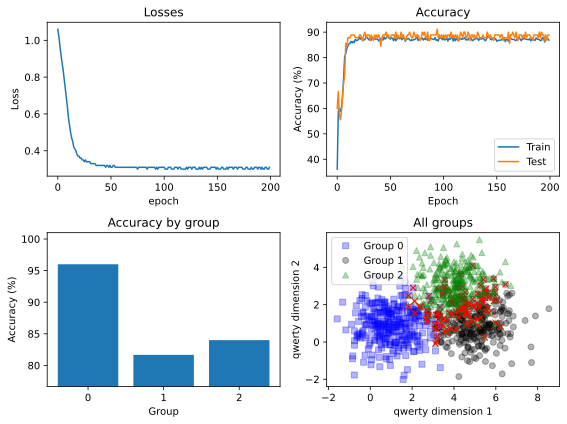

In [15]:
### Without Feature Augmentation!
ANN_model1,Lossfunc1,Optimizer1 = createTheQwertyNet(LR=0.01, useExtraFeature=False)

TrainAcc1,TestAcc1,Losses1,Trained_Model1 = function2trainTheModel(Model=ANN_model1,
                                                                lossfunc=Lossfunc1,
                                                                optimizer=Optimizer1,
                                                                train_loader=train_loader,
                                                                test_loader=test_loader,
                                                                epochs=200)

print(f'Final Test accuracy: {np.round(TestAcc1[-1].item(),2)}')

plotTheResults(trained_Model=Trained_Model1,
               dataAug=dataAug,
               labels=labels,
               trainAcc=TrainAcc1,
               testAcc=TestAcc1,
               losses=Losses1,
               useExtraFeature=False)

Final accuracy: 87.78


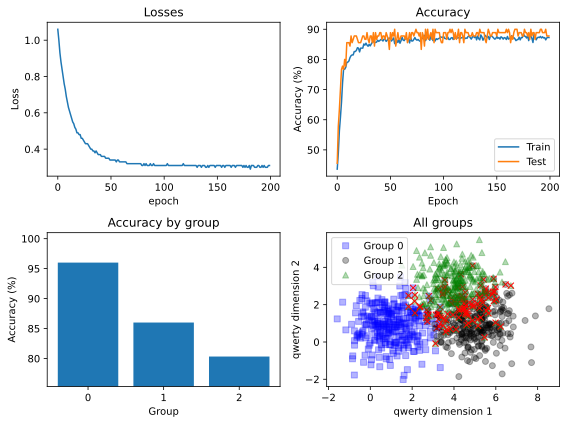

In [16]:
### With Feature Augmentation!
ANN_model2,Lossfunc2,Optimizer2 = createTheQwertyNet(LR=0.01, useExtraFeature=True)

TrainAcc2,TestAcc2,Losses2,Trained_Model2 = function2trainTheModel(Model=ANN_model2,
                                                                lossfunc=Lossfunc2,
                                                                optimizer=Optimizer2,
                                                                train_loader=train_loader,
                                                                test_loader=test_loader,
                                                                epochs=200)

print(f'Final accuracy: {np.round(TestAcc2[-1].item(),2)}')

plotTheResults(trained_Model=Trained_Model2,
               dataAug=dataAug,
               labels=labels,
               trainAcc=TrainAcc2,
               testAcc=TestAcc2,
               losses=Losses2,
               useExtraFeature=True)

### Conclusion : 
- Hard to find the difference in the performance of the two Model architectures.

## 11. t-test

In [17]:
len(TestAcc1)

200

### Run the experiment!

In [18]:
# Run the experiment multiple times and do a t-test!
# (takes ~5 mins)

finalacc2d = np.zeros(10)
finalacc3d = np.zeros(10)

for i in range(10):
    
    # Without Feature Augmentation!
    ANN_model1,Lossfunc1,Optimizer1 = createTheQwertyNet(LR=0.01, useExtraFeature=False)

    TrainAcc1,TestAcc1,Losses1,Trained_Model1 = function2trainTheModel(Model=ANN_model1,
                                                                lossfunc=Lossfunc1,
                                                                optimizer=Optimizer1,
                                                                train_loader=train_loader,
                                                                test_loader=test_loader,
                                                                epochs=200)
    
    finalacc2d[i] = np.round(np.mean(TestAcc1[-5:]),3)
    
    # With Feature Augmentation!
    ANN_model2,Lossfunc2,Optimizer2 = createTheQwertyNet(LR=0.01, useExtraFeature=True)

    TrainAcc2,TestAcc2,Losses2,Trained_Model2 = function2trainTheModel(Model=ANN_model2,
                                                                lossfunc=Lossfunc2,
                                                                optimizer=Optimizer2,
                                                                train_loader=train_loader,
                                                                test_loader=test_loader,
                                                                epochs=200)
    
    finalacc3d[i] = np.round(np.mean(TestAcc2[-5:]),3)

In [19]:
# show the numbers
print(np.round(np.vstack( (finalacc2d,finalacc3d) ).T,3))

[[89.334 89.334]
 [88.668 88.224]
 [89.556 87.778]
 [89.112 88.668]
 [88.668 88.446]
 [88.446 89.112]
 [88.002 88.446]
 [89.334 88.668]
 [88.446 87.336]
 [88.668 87.78 ]]


In [20]:
from scipy import stats

In [21]:
# run the t-test and print the results

# This is a test for the null hypothesis that 2 independent samples
# have identical average (expected) values. 
# This test assumes that the populations have identical variances by default.

# Null Hypothesis : two samples are identicals
t,p = stats.ttest_ind(finalacc3d,finalacc2d)
print('\n\nt=%.2f, p=%.2f' %(t,p))



t=-1.78, p=0.09


### Conclusion :
p value is 0.09 which is greater than 0.05
- Accept the Null Hypothesis
- two sample are : Identical
- Hence, two model architectures are : Same
- Therefore use the simple model Architecture